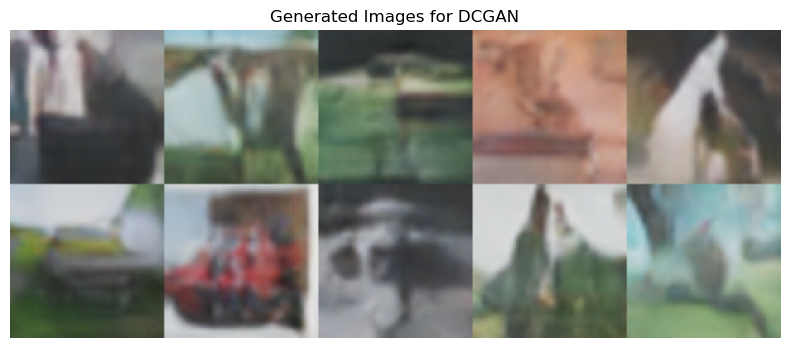

Generated images saved to generated_images_dcgan.png


In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

# Generator Model (same architecture as your original code)
class Generator(nn.Module):
    def __init__(self, noise_dim, text_dim, img_channels):
        super(Generator, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(text_dim, 256),
            nn.ReLU(inplace=True)
        )
        self.model = nn.Sequential(
            nn.Linear(noise_dim + 256, 4 * 4 * 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4 * 4 * 512),
            nn.Unflatten(1, (512, 4, 4)),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, img_channels, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )

    def forward(self, noise, text):
        text_embed = self.text_embedding(text)
        noise = noise.view(noise.size(0), -1)
        merged_input = torch.cat((noise, text_embed), dim=1)
        return self.model(merged_input)

# Parameters
NOISE_DIM = 100
TEXT_DIM = 119
IMG_CHANNELS = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained generator
generator = Generator(NOISE_DIM, TEXT_DIM, IMG_CHANNELS).to(device)
generator.load_state_dict(torch.load("models/generator_epoch_100.pth"))
generator.eval()

# Generate 10 images
def generate_images(generator, num_images=10, save_path="generated_images_dcgan.png"):
    noise = torch.randn(num_images, NOISE_DIM, device=device)
    random_labels = torch.randint(0, TEXT_DIM, (num_images,), device=device)
    conditions = nn.functional.one_hot(random_labels, num_classes=TEXT_DIM).float()
    with torch.no_grad():
        fake_images = generator(noise, conditions)
    fake_images = (fake_images + 1) / 2  # Scale to [0, 1] for visualization

    # Display and save the images using Matplotlib
    grid_img = make_grid(fake_images.cpu(), nrow=5, padding=0)
    np_grid = grid_img.permute(1, 2, 0).numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np_grid)
    plt.axis('off')
    plt.title('Generated Images for DCGAN')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.show()
    print(f"Generated images saved to {save_path}")

# Generate and save images
generate_images(generator)

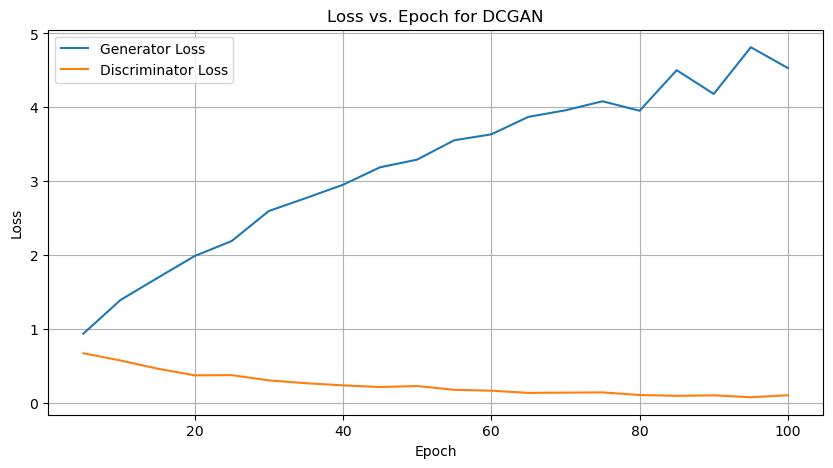

Loss vs. Epoch plot saved to loss_vs_epoch_dcgan.png


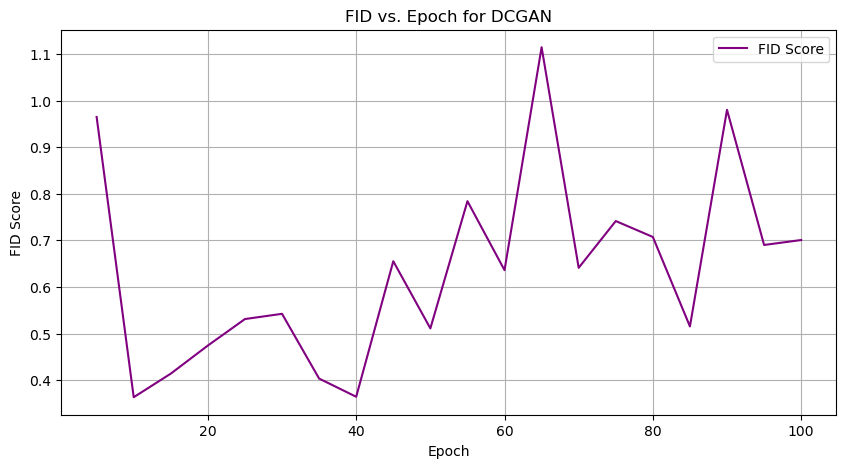

FID vs. Epoch plot saved to fid_vs_epoch_dcgan.png


In [8]:
# Plot Loss vs. Epoch and FID vs. Epoch
def plot_metrics(log_file, save_loss_plot="loss_vs_epoch_dcgan.png", save_fid_plot="fid_vs_epoch_dcgan.png"):
    # Load the log file
    df = pd.read_csv(log_file)

    # Plot Loss vs. Epoch
    plt.figure(figsize=(10, 5))
    plt.plot(df['Epoch'], df['Generator Loss'], label="Generator Loss")
    plt.plot(df['Epoch'], df['Discriminator Loss'], label="Discriminator Loss")
    plt.title("Loss vs. Epoch for DCGAN")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(save_loss_plot)
    plt.show()
    print(f"Loss vs. Epoch plot saved to {save_loss_plot}")

    # Plot FID vs. Epoch
    if 'FID Score' in df.columns:
        plt.figure(figsize=(10, 5))
        plt.plot(df['Epoch'], df['FID Score'], label="FID Score", color="purple")
        plt.title("FID vs. Epoch for DCGAN")
        plt.xlabel("Epoch")
        plt.ylabel("FID Score")
        plt.legend()
        plt.grid(True)
        plt.savefig(save_fid_plot)
        plt.show()
        print(f"FID vs. Epoch plot saved to {save_fid_plot}")
    else:
        print("FID scores are not available in the log file.")

# Plot metrics
plot_metrics("logs/training_log.csv")
